In [1]:
!pip install --upgrade PyDOE

Requirement already up-to-date: PyDOE in /usr/local/lib/python3.7/dist-packages (0.3.8)


In [2]:
import jax.numpy as np
import numpy as onp
from jax import vmap, jit, vjp, random
from jax.scipy.linalg import cholesky, solve_triangular

from jax.config import config
config.update("jax_enable_x64", True)

from pyDOE import lhs
from functools import partial
from tqdm import trange
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rc

onp.random.seed(1234)

In [3]:
# A vectorized RBF kernel function
def RBF(x1, x2, params):
    output_scale = params[0]
    lengthscales = params[1:]
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [4]:
# A wrapper to call SciPy's L-BFGS-B optimizer
def minimize_lbfgs(objective, x0, bnds = None):
    result = minimize(objective, x0, jac=True,
                      method='L-BFGS-B', bounds = bnds,
                      callback=None)
    return result.x, result.fun

In [5]:
# A minimal Gaussian process class
class GPRegression:
    # Initialize the class
    def __init__(self, kernel_fn = RBF, acq_fn = None): 
        self.kernel = kernel_fn
        self.acq_fn = acq_fn
                              
    def random_init_GP(self, rng_key, dim):
        logsigma_f = np.log(50.0*random.uniform(rng_key, (1,)))
        loglength  = np.log(random.uniform(rng_key, (dim,)) + 1e-8)
        logsigma_n = np.array([-4.0]) + random.normal(rng_key, (1,))
        hyp = np.concatenate([logsigma_f, loglength, logsigma_n])
        return hyp

    def compute_cholesky(self, params, batch):
        X, _ = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernel
        K = self.kernel(X, X, theta) + np.eye(N)*(sigma_n + 1e-8)
        L = cholesky(K, lower=True)
        return L

    def likelihood(self, params, batch):
        _, y = batch
        N = y.shape[0]
        # Compute Cholesky
        L = self.compute_cholesky(params, batch)
        # Compute negative log-marginal likelihood
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        NLML = 0.5*np.matmul(np.transpose(y),alpha) + \
               np.sum(np.log(np.diag(L))) + 0.5*N*np.log(2.0*np.pi)
        return NLML

    @partial(jit, static_argnums=(0,))
    def likelihood_value_and_grad(self, params, batch):
        fun = lambda params: self.likelihood(params, batch)
        primals, f_vjp = vjp(fun, params)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def train(self, batch, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays (to be minimized with SciPy)
        def objective(params):
            value, grads = self.likelihood_value_and_grad(params, batch)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        params = []
        likelihood = []
        X, _ = batch
        dim = X.shape[1]
        rng_key = random.split(rng_key, num_restarts)
        for i in trange(num_restarts):
            init = self.random_init_GP(rng_key[i], dim)
            p, val = minimize_lbfgs(objective, init)
            params.append(p)
            likelihood.append(val)
        params = np.vstack(params)
        likelihood = np.vstack(likelihood)
        #### find the best likelihood (excluding any NaNs) ####
        bestlikelihood = np.nanmin(likelihood)
        idx_best = np.where(likelihood == bestlikelihood)
        idx_best = idx_best[0][0]
        best_params = params[idx_best,:]
        return best_params

    @partial(jit, static_argnums=(0,))
    def predict(self, params, batch, X_star):
        X, y = batch
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean, std
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        std = np.sqrt(np.clip(np.diag(cov), a_min=0.))
        return mu, std

    @partial(jit, static_argnums=(0,))
    def draw_posterior_sample(self, rng_key, params, batch, X_star):
        X, y = batch
        N, D = X.shape
        # Fetch params
        sigma_n = np.exp(params[-1])
        theta = np.exp(params[:-1])
        # Compute kernels
        k_pp = self.kernel(X_star, X_star, theta) + np.eye(X_star.shape[0])*(sigma_n + 1e-8)
        k_pX = self.kernel(X_star, X, theta)
        L = self.compute_cholesky(params, batch)
        alpha = solve_triangular(L.T,solve_triangular(L, y, lower=True))
        beta  = solve_triangular(L.T,solve_triangular(L, k_pX.T, lower=True))
        # Compute predictive mean
        mu = np.matmul(k_pX, alpha)
        cov = k_pp - np.matmul(k_pX, beta)
        sample = random.multivariate_normal(rng_key, mu, cov)
        return sample    

    def acquisition(self, params, batch, x):
        x = x[None,:]
        mean, std = self.predict(params, batch, x)
        if self.acq_fn == 'LCB':
            NotImplementedError
        elif self.acq_fn == 'PI':
            NotImplementedError
        elif self.acq_fn == 'EI':
            NotImplementedError            
        elif self.acq_fn == 'US':
            return -std[0]
        else:
            raise NotImplementedError

    @partial(jit, static_argnums=(0,))
    def acq_value_and_grad(self, params, batch, x):
        fun = lambda x: self.acquisition(params, batch, x)
        primals, f_vjp = vjp(fun, x)
        grads = f_vjp(np.ones_like(primals))[0]
        return primals, grads

    def next_best_point(self, params, batch, bounds, rng_key, num_restarts = 10):
        # Define objective that returns NumPy arrays
        def objective(x):
            x = (x - lb)/(ub-lb)
            value, grads = self.acq_value_and_grad(params, batch, x)
            out = (onp.array(value), onp.array(grads))
            return out
        # Optimize with random restarts
        loc = []
        acq = []
        lb, ub = bounds
        dim = lb.shape[0]
        onp.random.seed(rng_key[0])
        x0 = lb + (ub-lb)*lhs(dim, num_restarts)
        dom_bounds = tuple(map(tuple, np.vstack((lb, ub)).T))
        for i in trange(num_restarts):
            pos, val = minimize_lbfgs(objective, x0[i,:], bnds = dom_bounds)
            loc.append(pos)
            acq.append(val)
        loc = np.vstack(loc)
        acq = np.vstack(acq)
        idx_best = np.argmin(acq)
        x_new = loc[idx_best:idx_best+1,:]
        return x_new

In [6]:
def branin():
    dim = 2
    lb = np.array([-5.0, 0.0])
    ub = np.array([10.0, 15.0])
    def f(x):
        a = 1.0
        b = 5.1 / (4*np.pi**2)
        c = 5 / np.pi
        r = 6
        s = 10
        t = 1 / (8*np.pi)
        x1, x2 = x[0], x[1]
        y = a * (x2 - b*x1**2 + c*x1 -r)**2 + s * (1-t) * np.cos(x1) + s
        return y
    return f, dim, (lb, ub)

In [7]:
# Define test function
f, dim, bounds = branin()

# Problem settings
N = 10
noise = 0.0
lb, ub = bounds

# Initial training data
X = lb + (ub-lb)*lhs(dim, N)
y = vmap(f)(X)
y = y + noise*y.std(0)*onp.random.randn(N,)

# Test data
nn = 80
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], 
                          YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

# Normalized test inputs
X_test = (X_star - lb)/(ub-lb)

In [8]:
model = GPRegression(kernel_fn = RBF, acq_fn = 'US')

In [9]:
# Active learning loop
num_iter = 25
error_log = []

for it in range(num_iter):
    print('\n')
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, num_iter))
    print('-------------------------------------------------------------------')

    # Normalize training data
    mu_y, sigma_y = y.mean(0), y.std(0)
    X_train = (X - lb)/(ub-lb)
    y_train = (y - mu_y)/sigma_y

    # Train model
    print('\nTrain GP...')
    train_key = random.PRNGKey(it)
    opt_params = model.train((X_train, y_train), train_key, num_restarts = 50)

    # Select next best point
    print('\nCompute next acquisition point...')
    new_X = model.next_best_point(opt_params, (X_train, y_train), bounds, train_key, num_restarts = 50)

    # Acquire data
    new_y = vmap(f)(new_X)
    new_y = new_y + noise*new_y.std(0)*onp.random.randn(1,)

    # Augment training data
    X = np.concatenate([X, new_X], axis = 0)
    y = np.concatenate([y, new_y], axis = 0)

    # Monitor prediction error
    mean, std = model.predict(opt_params, (X_train, y_train), X_test)
    mean, std = mean*sigma_y + mu_y, std*sigma_y      # De-normalize predictions
    error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
    print('\nRelative L2 error: %e\n' % (error))
    error_log.append(error)



-------------------------------------------------------------------
------------------------- Iteration 1/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 4.892676e-01



-------------------------------------------------------------------
------------------------- Iteration 2/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 4.655148e-01



-------------------------------------------------------------------
------------------------- Iteration 3/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 4.517609e-01



-------------------------------------------------------------------
------------------------- Iteration 4/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 4.324884e-01



-------------------------------------------------------------------
------------------------- Iteration 5/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 4.056302e-01



-------------------------------------------------------------------
------------------------- Iteration 6/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 2.523598e-01



-------------------------------------------------------------------
------------------------- Iteration 7/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 2.330674e-01



-------------------------------------------------------------------
------------------------- Iteration 8/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 1.310621e-01



-------------------------------------------------------------------
------------------------- Iteration 9/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 1.280656e-01



-------------------------------------------------------------------
------------------------- Iteration 10/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 1.267082e-01



-------------------------------------------------------------------
------------------------- Iteration 11/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 1.315728e-01



-------------------------------------------------------------------
------------------------- Iteration 12/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 4.729512e-02



-------------------------------------------------------------------
------------------------- Iteration 13/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 4.003714e-02



-------------------------------------------------------------------
------------------------- Iteration 14/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 3.756560e-02



-------------------------------------------------------------------
------------------------- Iteration 15/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 3.254708e-02



-------------------------------------------------------------------
------------------------- Iteration 16/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 1.594347e-02



-------------------------------------------------------------------
------------------------- Iteration 17/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 1.505315e-02



-------------------------------------------------------------------
------------------------- Iteration 18/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 1.511438e-02



-------------------------------------------------------------------
------------------------- Iteration 19/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 1.343412e-02



-------------------------------------------------------------------
------------------------- Iteration 20/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 8.589939e-03



-------------------------------------------------------------------
------------------------- Iteration 21/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 9.736381e-03



-------------------------------------------------------------------
------------------------- Iteration 22/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 8.295374e-03



-------------------------------------------------------------------
------------------------- Iteration 23/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 6.024432e-03



-------------------------------------------------------------------
------------------------- Iteration 24/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


  0%|          | 0/50 [00:00<?, ?it/s]


Relative L2 error: 4.959614e-03



-------------------------------------------------------------------
------------------------- Iteration 25/25 -------------------------
-------------------------------------------------------------------

Train GP...


  0%|          | 0/50 [00:00<?, ?it/s]


Compute next acquisition point...


100%|██████████| 50/50 [00:01<00:00, 27.64it/s]



Relative L2 error: 2.515317e-03



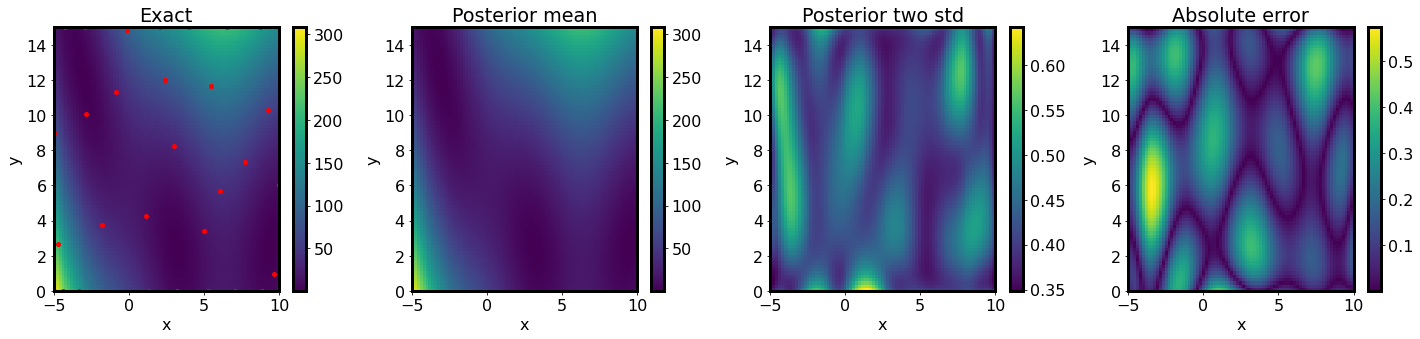

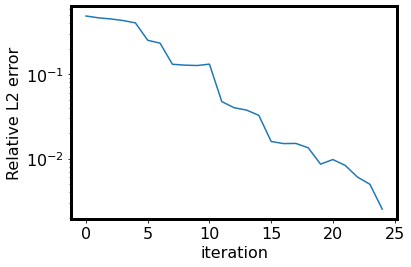

In [10]:
# Plot
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3

plt.figure(figsize = (20,5))
plt.subplot(1,4,1)
plt.pcolor(XX, YY, y_star.reshape(nn,nn))
plt.colorbar()
plt.plot(X[:,0], X[:,1], 'ro', ms=4)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact')
plt.tight_layout()

plt.subplot(1,4,2)
plt.pcolor(XX, YY, mean.reshape(nn,nn))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Posterior mean')
plt.tight_layout()

plt.subplot(1,4,3)
plt.pcolor(XX, YY, 2.0*std.reshape(nn,nn))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Posterior two std')
plt.tight_layout()

plt.subplot(1,4,4)
plt.pcolor(XX, YY, np.abs(y_star-mean).reshape(nn,nn))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute error')
plt.tight_layout()

plt.figure()
plt.plot(error_log)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('Relative L2 error')
plt.tight_layout()